# Back Propagation

- Write a simple neural networks without framework (e.g. Tensorflow, PyTorch)
- Only use Numpy and other standard lib
- NN with two hidden layers
- Plot your comparison figure that show the predict result and ground truth

## Implementation

- x1,x2 : NN inputs
- y : NN output
- L($\theta$) : Lost function
- W : weight matrix
- $\sigma$ : activation function $\frac{1}{1+e^{-x}}$

In [1]:
%run lab1.py

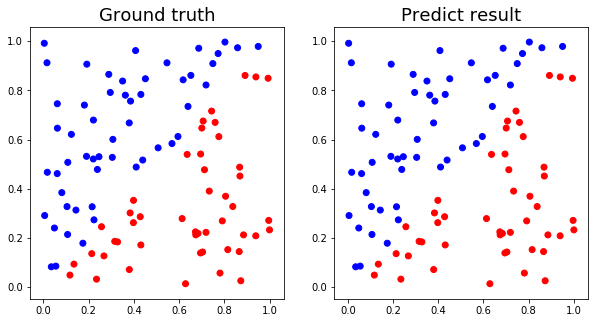

In [4]:
x, y = generate_linear()
show_result(x, y, y)

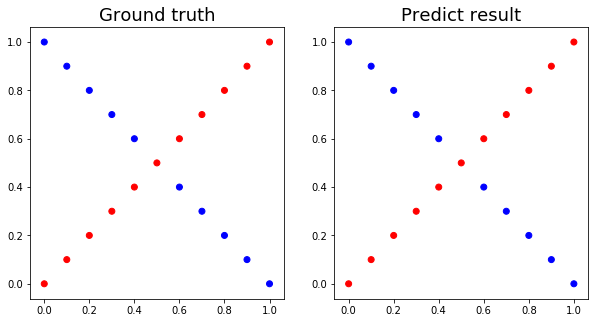

In [3]:
x, y = generate_XOR_easy()
show_result(x, y, y)